In [1]:
from flax import linen as nn
from flax import optim

import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax

from nvif import NVIF

import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

# Instantiating the model
The algorithm introduced in this repository allows for approximate learning and inference in temporal models with binary latent states. In this notebook, we show an example of how this algorithm can be used in the context of Non-Intrusive Load Monitoring (NILM). The algorithm requires instances of $\log p(z_t|z_{t-1})$ and $\log p(x_t|z_{t})$. The latent state $z_t$ is multivariate and binary, i.e. $z_t \in \{0,1\}^{z\_dim}$.

## State transition model
In the following, we assume that the not many appliances change state from one point in time to the next. Specifically, we assume the number of switches that occur follows a geometric distribution. These probabilities are normalized such that $\sum_{z_t} p(z_t|z_{t-1}) = 1$.

Note that $p\_zz$ needs to be a $flax.linen.Module$ whose $\_\_call\_\_$ takes two arguments, $zt$ and $ztm1$ with shapes $(num\_samples \times z\_dim)$ each and outputs the log probability for each combination of states, i.e. the output has shape $(num\_samples \times num\_samples)$.

In [2]:
class p_zz(nn.Module):
    
    z_dim: int
    
    def setup(self):
        
        p = 0.75
        
        geo = lambda k: k*np.log(1-p) + np.log(p)            
        probs = geo(np.arange(z_dim))
        Zs = np.log(scipy.special.comb(z_dim, np.arange(z_dim)))
            
        Zs = jnp.array(Zs) + probs
        probs = jnp.array(probs)
        probs = probs-logsumexp(Zs) #normalizing probabilities
        
        self.probs = probs


    def __call__(self, zt, ztm1):
        
        k = jnp.sum(jnp.abs(ztm1[None] - zt[:,None]), -1).astype(jnp.int32)
        return self.probs[k]

## Observation model
We assume that the observation is a multivariate Gaussian distribution with diagonal covariance. The observation model has a free parameter (or weights) that describe the waveforms of appliances. Thus, $p(x_t|z_t) = \mathcal{N}(x_t | \mu = Wz_t, \sigma^2 = 0.015)$. Note that it is not recommended to let $\sigma^2$ be a free parameter because the model will choose a large $\sigma^2$ and not explain smaller components away.

Note that $p\_xz$ needs to be a $flax.linen.Module$ whose $\_\_call\_\_$ takes two arguments, $xt$ and $zt$ with shapes $(num\_steps \times x\_dim)$ and $(num\_steps \times num\_samples \times z\_dim)$ respectively and outputs the log probability for each state, i.e. the output has shape $(num\_steps \times num\_samples)$. Unlike $p\_zz$, $p\_xz$ has a leading 'batch dimension'.

In [3]:
class p_xz(nn.Module):
    
    x_dim: int
    
    @nn.compact
    def __call__(self, x, z):
        
        xhat = nn.Dense(features=self.x_dim, use_bias=False)(z)
        sgm = jnp.sqrt(0.015)

        if len(xhat.shape) > 2:
            x = x[:,None]
            
        return -jnp.mean((x - xhat)**2 / (2 * sgm**2) + jnp.log(sgm), axis=-1)

## Generating synthetic NILM data

In the following, synthetic NILM data is generated. We assume that only a small number of appliances switch states and that current waveforms have been measured. By changing $z\_dim$ to 2, this algorithm can easily be adapted to disaggregate active and reactive power.

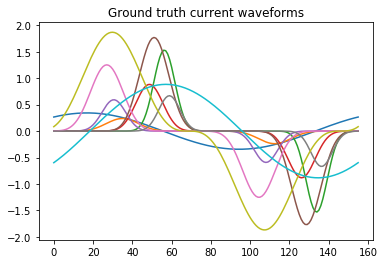

In [4]:
def generate_waveforms(x_dim, N=15):

    np.random.seed(42069) #for reproducibility
    phase_shift = np.random.uniform(-0.3*np.pi, 0.3*np.pi, (N,))
    exponent = np.random.geometric(0.075, (N,))*2-1
    A = np.random.uniform(0.15, 2.0, (N,1))
    
    W = np.array([np.sin(np.linspace(0, 2*np.pi, x_dim) - phase_shift[i])**exponent[i] for i in range(N)])
    return A*W


def generate_state_seq(T, N=15):
    np.random.seed(69) #for reproducibility
    
    state_seq = [np.random.binomial(1, 0.2, (N,))]
    for _ in range(T-1):
        num_switches = np.random.geometric(0.75)
        switches = np.random.choice(N, size=(num_switches,), replace=False)
        
        z_in = state_seq[-1].copy()
        for sw in switches:
            z_in[sw] = 1 - z_in[sw]
            
        state_seq.append(z_in)
        
    return np.array(state_seq)


def generate_synthetic(T, x_dim, N=15):
    '''
    Gaussian measurement noise with sigma = 0.015
    '''
    W = generate_waveforms(x_dim, N)
    z = generate_state_seq(T, N)
    x = np.dot(z, W)
    x += np.random.normal(0, 0.015, x.shape) #additive noise
    
    return x, W, z

x, W, z = generate_synthetic(10000, 156, N=10)
_ = plt.plot(W.T)
_ = plt.title("Ground truth current waveforms")
x = jnp.array(x)

## Creating NVIF object
There are a couple of caveats when creating the NVIF object. When instantiating the model, do not pass the NVIF object an instance of $p\_zz$ and $p\_xz$ but rather the uninitialized module. If your models for $p\_zz$ or $p\_xz$ require key-word arguments in order to be initialized, pass them as a dictionary called $pzz\_cfg$ and $pxz\_cfg$ to the NVIF object, respectively.

Speed and accuracy for the algorithm can be traded off using $num\_samples$. As $num\_samples$ approaches infinity, NVIF 'becomes' the regular Expectation Maximization algorithm. Note that the algorithm scales quadratically with $num\_samples$.

In [5]:
key = jax.random.PRNGKey(1)
h_dim = 96
num_samples, num_steps = 1024, 256
z_dim, x_dim = 12, 156

N = NVIF(p_zz=p_zz, p_xz=p_xz, num_steps=num_steps, hidden_dim = h_dim,
         num_samples=num_samples, z_dim=z_dim, x_dim=x_dim,
         pzz_cfg = {'z_dim': z_dim}, pxz_cfg = {'x_dim': x_dim})

a = N.train(x[:9000], optimizer = optim.Adam(3E-3), num_epochs=150)

1/150 Epoch loss: 92.618, took seconds:67.940
2/150 Epoch loss: 44.179, took seconds:69.866
3/150 Epoch loss: 23.866, took seconds:80.813
4/150 Epoch loss: 17.188, took seconds:97.198
5/150 Epoch loss: 14.064, took seconds:116.095
6/150 Epoch loss: 12.027, took seconds:129.871
7/150 Epoch loss: 10.531, took seconds:135.650
8/150 Epoch loss: 9.520, took seconds:137.634
9/150 Epoch loss: 8.815, took seconds:137.279
10/150 Epoch loss: 8.171, took seconds:137.316
11/150 Epoch loss: 7.642, took seconds:138.785
12/150 Epoch loss: 7.219, took seconds:140.877
13/150 Epoch loss: 6.777, took seconds:143.426
14/150 Epoch loss: 6.189, took seconds:146.494
15/150 Epoch loss: 5.726, took seconds:148.729
16/150 Epoch loss: 5.478, took seconds:150.593
17/150 Epoch loss: 5.181, took seconds:152.662
18/150 Epoch loss: 4.879, took seconds:153.526
19/150 Epoch loss: 4.735, took seconds:153.399
20/150 Epoch loss: 4.645, took seconds:149.864
21/150 Epoch loss: 4.589, took seconds:148.142
22/150 Epoch loss: 

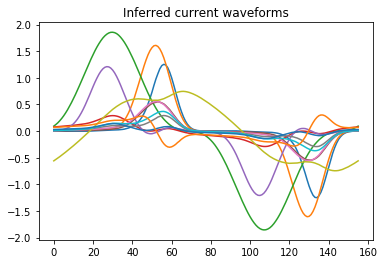

In [6]:
W_hat = N.optimizer.target['params']['pxz_fun']['Dense_0']['kernel']
_ = plt.plot(W_hat.T)
_ = plt.title("Inferred current waveforms")

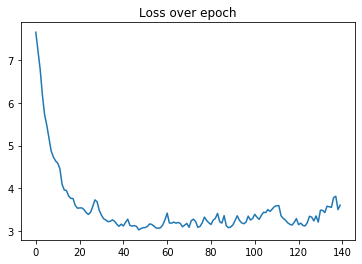

In [7]:
_ = plt.plot(N.losses[10:])
_ = plt.title("Loss over epoch")

In [10]:
z_hat = N.inference(x[9000:9300])
xhat = jnp.dot(z_hat, W_hat)

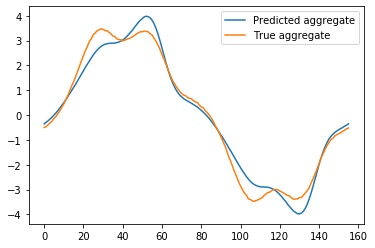

In [13]:
_ = plt.plot(xhat[131], label='Predicted aggregate')
_ = plt.plot(x[9130], label='True aggregate')
_ = plt.legend()

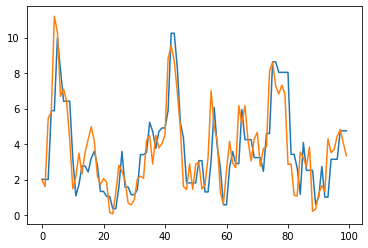

In [12]:
plt.plot(np.mean(xhat[:100]**2,-1))
plt.plot(np.mean(x[9000:9100]**2,-1))